In [2]:
import numpy as np
import scipy as sp
import json
from PIL import Image #pip install Pillow
from matplotlib import pyplot as plt
#from scipy.misc import imread


**Test image processing on the video**

In [3]:
import cv2
def read_video(video_path,duration=30): #limit to 1min video
    cap = cv2.VideoCapture(video_path)
    frames = []  # initalising empty frames
    fps = cap.get(cv2.CAP_PROP_FPS) # Get the frame rate (FPS) of the video
    
    frame_limit = int(fps * duration)
    frame_count = 0
    while frame_count < frame_limit:
        ret, frame = cap.read()
        if not ret:  # If the video ends before 1 minute
            break
        frames.append(frame)
        frame_count += 1
    cap.release()
    return frames 


def save_video(output_video_frames, output_video_path):
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Using the XVID codec

    if output_video_frames and hasattr(output_video_frames[0], 'shape'):
        frame_height, frame_width = output_video_frames[0].shape[:2]  # Get frame size
        out = cv2.VideoWriter(output_video_path, fourcc, 24, (frame_width, frame_height))
    else:
        raise ValueError("output_video_frames is either empty or the frames do not have a 'shape' attribute.")

    for frame in output_video_frames:
        out.write(frame)  # Write each frame to the output video

    out.release()

In [8]:
import pickle

# Load the model from the file
model_path = 'models/cnn_model.pkl'
with open(model_path, 'rb') as file:
    model = pickle.load(file)

print("Model loaded successfully!")

Model loaded successfully!


In [11]:
def detect_digits_and_draw_boxes(frames,model):
    processed_frames = []
    
    for frame in frames:
        # Convert frame to HSV color space
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Define the range for detecting orange color
        lower_orange = np.array([10, 110, 110])
        upper_orange = np.array([25, 255, 255])
        
        # Create a mask for orange color
        orange_mask = cv2.inRange(hsv_frame, lower_orange, upper_orange)
        orange_regions = cv2.bitwise_and(frame, frame, mask=orange_mask)
        
        # Convert the orange regions to grayscale
        gray_orange_only = cv2.cvtColor(orange_regions, cv2.COLOR_BGR2GRAY)
        
        # Apply thresholding to detect digits
        thresh = cv2.threshold(gray_orange_only, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

        inverted_thresh = cv2.bitwise_not(thresh)

        # apply an "opening" morphological operation to disconnect components
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        opening = cv2.morphologyEx(inverted_thresh, cv2.MORPH_OPEN, kernel)

        contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        chars=[]
        digit_images = []
        areaContour = []
        predictions = []
        recognized_digits = ""

        x_min, y_min = float('inf'), float('inf')
        x_max, y_max = 0, 0

        sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

        for contour in sorted_contours:
            x, y, w, h = cv2.boundingRect(contour)
            if h > 10 and w > 5: 

                    aspect_ratio = w / h
                    area = cv2.contourArea(contour)

                    if 0.2 < aspect_ratio < 1.0:
                        
                        x_min = min(x_min, x)
                        y_min = min(y_min, y)
                        x_max = max(x_max, x + w)
                        y_max = max(y_max, y + h)
                        
                        if area > 300:
                            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                            cropped_img = gray_orange_only[y:y + h, x:x + w]
                            ROI = cv2.threshold(cropped_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

                            resized_img = cv2.resize(ROI, (28, 28))
                            normalized_img = resized_img / 255.0
                            img_array = np.expand_dims(normalized_img, axis=(0, -1))
                            prediction = model.predict(img_array)
                            predictions.append(np.argmax(prediction, axis=1)[0])

                            recognized_digit = np.argmax(prediction, axis=1)[0]
                            recognized_digits += str(recognized_digit)


                            digit_images.append(normalized_img)
                            areaContour.append(area)

                            cv2.putText(frame, str(recognized_digit), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Add the processed frame to the list
        processed_frames.append(frame)
    
    return processed_frames,digit_images, predictions


def process_video(input_video_path, output_video_path):
    frames = read_video(input_video_path)
    processed_frames, digit_images, predictions = detect_digits_and_draw_boxes(frames, model)
    save_video(processed_frames, output_video_path)


In [12]:
input_video_path = 'input_video/sample1.mp4' 
output_video_path = 'output_video/output_video_with_20241015.avi'

process_video(input_video_path, output_video_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

In [ ]:
#https://stackoverflow.com/questions/58663227/extracting-digits-from-image-with-python-and-opencv

Model loaded successfully!


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from PIL import Image

def preprocess_image_with_orange_detection(image_path,model):

    img = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  
    lower_orange = np.array([10, 100, 100])
    upper_orange = np.array([25, 255, 255])
    
    orange_mask = cv2.inRange(hsv_img, lower_orange, upper_orange)
    orange_regions = cv2.bitwise_and(img, img, mask=orange_mask)
    
    gray_orange_only = cv2.cvtColor(orange_regions, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to detect digits
    thresh = cv2.threshold(gray_orange_only, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    inverted_thresh = cv2.bitwise_not(thresh)

    # apply an "opening" morphological operation to disconnect components
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3, 3))
    opening = cv2.morphologyEx(inverted_thresh, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    digit_images = []
    areaContour = []
    predictions = []
    recognized_digits = ""

    x_min, y_min = float('inf'), float('inf')
    x_max, y_max = 0, 0

    sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    for contour in sorted_contours:
        x, y, w, h = cv2.boundingRect(contour) 
        if h > 10 and w > 5:  

            aspect_ratio = w / h
            area = cv2.contourArea(contour)

            if 0.2 < aspect_ratio < 1.0:

                x_min = min(x_min, x)
                y_min = min(y_min, y)
                x_max = max(x_max, x + w)
                y_max = max(y_max, y + h)
            
                if area > 300:

                    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

                    cropped_img = gray_orange_only[y:y + h, x:x + w]
                    ROI = cv2.threshold(cropped_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

                    resized_img = cv2.resize(cropped_img, (28, 28))
                    normalized_img = resized_img / 255.0
                    img_array = np.expand_dims(normalized_img, axis=(0, -1))
                    prediction = model.predict(img_array)
                    predictions.append(np.argmax(prediction, axis=1)[0])
                    
                    recognized_digit = np.argmax(prediction, axis=1)[0]
                    recognized_digits += str(recognized_digit)

                    digit_images.append(normalized_img)
                    areaContour.append(area)

                    cv2.putText(img, str(recognized_digit), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    
    return digit_images, predictions



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


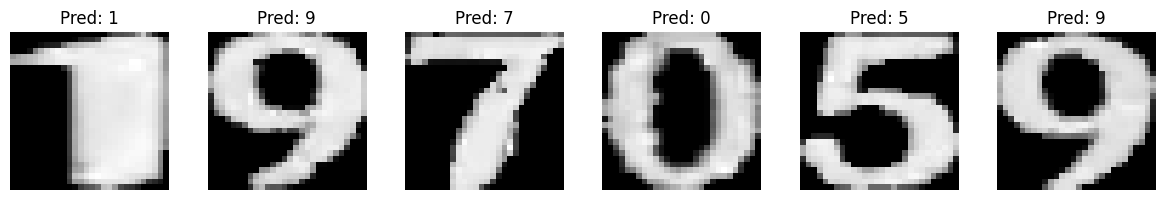

In [7]:

image_path = 'img/train/frame50.jpg'  

# Preprocess the image and detect digits
digit_images, predictions = preprocess_image_with_orange_detection(image_path,model)

# Plot the detected digits and their predictions in a grid
num_digits = len(digit_images)

# Set up a grid for subplots (1 row, multiple columns based on the number of digits)
fig, axes = plt.subplots(1, num_digits, figsize=(num_digits * 2, 2))  # Adjust the size as necessary

for i, ax in enumerate(axes):
    ax.imshow(digit_images[i], cmap='gray')
    ax.set_title(f'Pred: {predictions[i]}')
    ax.axis('off')  # Hide the axes for clarity

plt.tight_layout()
plt.show()